In [12]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from numpy import sqrt 
import time

#Tien Xu Ly
from sklearn.preprocessing import MinMaxScaler

#Draw Flot
import matplotlib.pyplot as plt

#Cacuale error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

#distance Libaray
from dtw import dtw
from scipy.spatial.distance import euclidean

#FFNN Libarary
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

In [13]:
# Đọc Dữ Liệu
# @param   filePath     Đường dẫn tập dữ liệu CSV
# @return  df           Tập dữ liệu csv dưới dạng df
def readData(filePath):
    # Load dữ liệu
    dataCSV = pd.read_csv(filePath)
    df=dataCSV[['Close']]
    return df

# Tiền Xử lý Dữ Liệu
# @param  Data   Tập dữ liệu
# @return df     Dữ liệu đã được tiền xử lý
def cleanData(df):
    # Replace null values with 0
    df.fillna(0, inplace=True)
    # Remove outliers by replacing values outside of 10 standard deviations with the mean
    std = df['Close'].std()
    mean = df['Close'].mean()
    df['Close'] = np.where(df['Close'] > (mean + 10*std), mean, df['Close'])
    df['Close'] = np.where(df['Close'] < (mean - 10*std), mean, df['Close'])
    # Scale data_AMZN to range [0, 1]
    scaler = MinMaxScaler()
    df['Close'] = scaler.fit_transform(df['Close'].values.reshape(-1, 1))
    # Fill in missing values with the mean of the previous and next values
    df['Close'] = df['Close'].interpolate(method='linear')
    return df

# Chia dữ liệu thành train set và test set
# @param  data                      Tập dữ liệu
# @param  percentTrain              Tỷ lệ Tập train
# @return train_data, test_data     Tập train và test   
def splitData(data, percentTrain):
    train_size = int(len(data) * (percentTrain/100))
    train = data.iloc[:train_size, :]
    test = data.iloc[train_size:, :]
    return train, test

# Xử lý dữ liệu thành dữ liệu đầu vào và đầu ra cho mô hình
# @param      data            Dữ liệu cần chia cửa sổ
# @param      size_window     Kích thước cửa sổ
# @param      size_predict    Kích thước cửa sổ dự đoán
# @param      stepWindow      số điểm dữ liệu trượt
# @return     X, y            mảng cửa sổ mẫu và mảng điểm dự đoán tương ứng
def prepare_data(data, size_window, size_predict, stepWindow):
    X, y = [], []
    startWindow = 0
    for i in range(len(data) - size_window - 1):
        if (len(data[(startWindow + size_window):(startWindow + size_window + size_predict) , 0]) != size_predict):
            break
        X.append(data[startWindow:(startWindow + size_window), :])
        y.append(data[(startWindow + size_window):(startWindow + size_window + size_predict) , 0])
        startWindow += stepWindow
    return np.array(X), np.array(y)

#---------KNN-----------
# Fucntion Tính khoảng cách giữa 2 chuỗi thời gian
# @param    ts1            Chuỗi thứ nhất
# @param    ts2            Chuỗi thứ hai
# @return   euclidean      Khoảng cách euclidean    
def euclidean_distance(ts1, ts2):
    ts1= ts1.flatten()
    ts2= ts2.flatten()
    return euclidean(ts1,ts2)

# Function lấy ra k chuỗi gần nhất
# @param    k             Số lượng chuỗi gần nhất
# @param    distanceArr   Mảng khoảng cách
# @return   argsort       Vị trí chuỗi gần nhất        
def kSimilarityTimeSeries(k, distanceArr):
    distances = np.array(distanceArr)
    return distances.argsort()[:k] 

# Tính khoảng cách DTW
# @param    ts1            Chuỗi thứ nhất
# @param    ts2            Chuỗi thứ hai
# @return   euclidean      Khoảng cách euclidean  
def dtw_dist(ts1, ts2):
    dist, _, _, _ = dtw(ts1, ts2, dist=lambda ts1, ts2: np.abs(ts1 - ts2))
    return dist

# Thêm Dữ liệu
# @param    X_train               Cửa sổ mẫu train
# @param    y_train               Cửa sổ dự đoán train
# @param    XTest                 Cửa sổ mẫu test
# @param    yTest                 Cửa sổ dự đoán test
# @return   X_train, y_train      Khoảng cách euclidean 
def toTrain(X_train, y_train, XTest, yTest):
    X_train.append(XTest)
    y_train.append(yTest)
    return np.array(X_train), np.array(y_train)

# Dự đoán Euclidean
# @param    nameData           Tên tập dữ liệu
# @param    k                  Số lượng chuỗi gần nhất
# @param    typeDistance       Độ đo sử dụng (Dtw, euclidean)
# @param    X_train            Cửa sổ mẫu train
# @param    y_train            Cửa sổ dự đoán train
# @param    X_test             Cửa sổ mẫu test
# @param    y_test             Cửa sổ dự đoán test
# @return   y_pred_arr         Mảng dự đoán
def predict_KNN(k, typeDistance, X_train, y_train, X_test, y_test):
    y_pred_arr=[]
    for iTest in range(len(X_test)):
        if(k>len(X_train)):
            k=len(X_train)
        distanceArr=[]
        for iTrain in range(len(X_train)-size_window+2):
            if(typeDistance == 'Dtw'):
                distance = dtw_dist(X_test[iTest],X_train[iTrain])
            else:
                distance = euclidean_distance(X_test[iTest],X_train[iTrain])
            distanceArr.append(distance)
        indexKNN= kSimilarityTimeSeries(k,distanceArr)
        y_pred = np.mean(y_train[indexKNN])
        y_pred_arr.append(y_pred)
        X_train, y_train = toTrain(X_train.tolist(), y_train.tolist(),X_test[iTest].tolist(), y_test[iTest].tolist())
        y_pred = np.array(y_pred_arr)
   
    return y_pred


#----------------FFNN--------------------------
# Khởi tạo mô hình FFNN
# @param    neuralInput         Kích thước Cửa sổ mẫu/ số neural lớp input
# @param    num_layers_hidden   Số lượng lớp ẩn
# @param    num_neural_hidden   Số neural lớp ẩn
# @param    neuralOutput         Số neural lớp ouput
# @return   model               Mô hình FFNN
def create_model_FFNN(neuralInput, num_layers_hidden=1, neuralHidden=1, neuralOutput=1):
    model = Sequential()
    for i in range(num_layers_hidden):
        if i == 0:
            model.add(Dense(neuralHidden, input_dim= neuralInput, activation='sigmoid'))
        else:
            model.add(Dense(neuralHidden, activation='sigmoid'))
    model.add(Dense(neuralOutput))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


# Train FFNN 
# @param    nameData          Tên tập dữ liệu
# @param    size_window       Kích thước Cửa sổ mẫu/ số neural lớp input
# @param    X_train           cửa sổ mẫu tập train
# @param    y_train           Cửa sổ dự đoán tập train
# @param    neuralHidden      Số neural lớp ẩn
# @param    numHiddenLayer    Số lớp ẩn
# @param    size_predict      Kích thước Cửa sổ dự đoán/ Số neural lớp ouput
# @return   best_params_FFNN  Tham số tốt nhất cho mô hình FFNN                
def train_FFNN(nameData, typePredict, size_window, X_train, y_train, neuralHidden, numHiddenLayer, size_predict):
    #param search
    param_grid_FFNN = {'batch_size': [8, 16, 32, 64, 128],
              'epochs': [50, 100, 150, 200, 250, 300],
              'neuralHidden': [neuralHidden],
              'num_layers_hidden' : [numHiddenLayer],
              'neuralInput' : [size_window],
              'neuralOutput' : [size_predict]}

    # create the model
    model_FFNN = KerasRegressor(build_fn=create_model_FFNN, verbose=0)
    
    # perform the grid search
    grid_FFNN = GridSearchCV(estimator=model_FFNN, param_grid=param_grid_FFNN, cv=3)
    grid_result_FFNN = grid_FFNN.fit(X_train, y_train)
    
    # train the model with the best parameters
    best_params_FFNN = grid_result_FFNN.best_params_
    
    model_FFNN = create_model_FFNN( best_params_FFNN['neuralInput'], best_params_FFNN['num_layers_hidden'], best_params_FFNN['neuralHidden'],best_params_FFNN['neuralOutput'])
    model_FFNN.fit(X_train, y_train, epochs=best_params_FFNN['epochs'], batch_size=best_params_FFNN['batch_size'], verbose=2, callbacks=[EarlyStopping(monitor='loss', patience=10)], shuffle=False)
    
    if(typePredict=='FFNN_Find_NeuralHidden'):
        model_FFNN.save_weights('../BestParam/FFNN/'+nameData+'/FFNN_Find_NeuralHidden/'+str(int(best_params_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(best_params_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(best_params_FFNN['batch_size']))+'_BatchSize_'+str(int(best_params_FFNN['epochs']))+'_Epoch_'+nameData+'.h5')   
    elif (typePredict=='FFNN_Find_NumberHiddenLayer'):
        model_FFNN.save_weights('../BestParam/FFNN/'+nameData+'/FFNN_Find_NumberHiddenLayer/'+str(int(best_params_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(best_params_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(best_params_FFNN['batch_size']))+'_BatchSize_'+str(int(best_params_FFNN['epochs']))+'_Epoch_'+nameData+'.h5')   
    else:
        model_FFNN.save_weights('../BestParam/TuanTu/'+nameData+'/FFNN_Find_NumberHiddenLayer/'+str(int(best_params_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(best_params_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(best_params_FFNN['batch_size']))+'_BatchSize_'+str(int(best_params_FFNN['epochs']))+'_Epoch_'+nameData+'.h5')   
    return best_params_FFNN



# Train FFNN 
# @param    nameData          Tên tập dữ liệu
# @param    size_window       Kích thước Cửa sổ mẫu/ số neural lớp input
# @param    X_train           cửa sổ mẫu tập train
# @param    y_train           Cửa sổ dự đoán tập train
# @param    batchSize         Số lượng mẫu được đưa vào với mỗi lần lặp (epoch)
# @param    epoch             Số lần lặp cập nhật trọng số
# @param    neuralHidden      Số neural lớp ẩn
# @param    numHiddenLayer    Số lớp ẩn
# @param    size_predict      Kích thước Cửa sổ dự đoán/ Số neural lớp ouput
# @return   best_params_FFNN  Tham số tốt nhất cho mô hình FFNN                
def train_best_param_FFNN(nameData, typePredict, size_window, X_train, y_train, batchSize, epoch, neuralHidden, numHiddenLayer, size_predict):
    #param search
    param_grid_FFNN = {'batch_size': batchSize,
              'epochs': epoch,
              'neuralHidden': neuralHidden,
              'num_layers_hidden' : numHiddenLayer,
              'neuralInput' : size_window,
              'neuralOutput' : size_predict}
    
    model_FFNN = create_model_FFNN( param_grid_FFNN['neuralInput'], param_grid_FFNN['num_layers_hidden'], param_grid_FFNN['neuralHidden'],param_grid_FFNN['neuralOutput'])
    model_FFNN.fit(X_train, y_train, epochs=param_grid_FFNN['epochs'], batch_size=param_grid_FFNN['batch_size'], verbose=2, callbacks=[EarlyStopping(monitor='loss', patience=10)], shuffle=False)
    
    if(typePredict=='FFNN_Find_NeuralHidden'):
        model_FFNN.save_weights('../BestParam/FFNN/'+nameData+'/FFNN_Find_NeuralHidden/'+str(int(param_grid_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(param_grid_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(param_grid_FFNN['batch_size']))+'_BatchSize_'+str(int(param_grid_FFNN['epochs']))+'_Epoch_'+nameData+'.h5')   
    elif (typePredict=='FFNN_Find_NumberHiddenLayer'):
        model_FFNN.save_weights('../BestParam/FFNN/'+nameData+'/FFNN_Find_NumberHiddenLayer/'+str(int(param_grid_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(param_grid_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(param_grid_FFNN['batch_size']))+'_BatchSize_'+str(int(param_grid_FFNN['epochs']))+'_Epoch_'+nameData+'.h5')   
    elif (typePredict=='FFNN_Find_NumberHiddenLayer_SongSong'):
        model_FFNN.save_weights('../BestParam/SongSong/'+nameData+'/FFNN_Find_BestWeights/'+str(int(param_grid_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(param_grid_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(param_grid_FFNN['batch_size']))+'_BatchSize_'+str(int(param_grid_FFNN['epochs']))+'_Epoch_'+nameData+'.h5')   
    else:
        model_FFNN.save_weights('../BestParam/TuanTu/'+nameData+'/FFNN_Find_BestWeights/'+str(int(param_grid_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(param_grid_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(param_grid_FFNN['batch_size']))+'_BatchSize_'+str(int(param_grid_FFNN['epochs']))+'_Epoch_'+nameData+'.h5')   
   
    return param_grid_FFNN

# Dự Đoán FFNN 
# @param    nameData          Tên tập dữ liệu
# @param    typePredict       Thực hiện loại dự đoán (FFNN_Find_NeuralHidden,FFNN_Find_NumberHiddenLayer,CombinePredict)
# @param    X_train           cửa sổ mẫu tập train
# @param    y_train           Cửa sổ dự đoán tập train
# @param    X_test            Cửa sổ dự đoán tập train
# @param    best_params_FFNN  Cửa sổ dự đoán tập train
# @return   predictions_FFNN  Mảng dự đoán
def predict_FFNN(nameData, typePredict, X_train, y_train, X_test, best_params_FFNN):
    model_FFNN1 = Sequential()
    for i in range(best_params_FFNN['num_layers_hidden']):
        if i == 0:
            model_FFNN1.add(Dense(best_params_FFNN['neuralHidden'], input_dim= best_params_FFNN['neuralInput'], activation='sigmoid'))
        else:
            model_FFNN1.add(Dense(best_params_FFNN['neuralHidden'], activation='sigmoid'))
    model_FFNN1.add(Dense(best_params_FFNN['neuralOutput']))
    
    if(typePredict=='FFNN_Find_NeuralHidden'):
        model_FFNN1.load_weights('../BestParam/FFNN/'+nameData+'/FFNN_Find_NeuralHidden/'+str(int(best_params_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(best_params_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(best_params_FFNN['batch_size']))+'_BatchSize_'+str(int(best_params_FFNN['epochs']))+'_Epoch_'+nameData+'.h5')   
    elif (typePredict=='FFNN_Find_NumberHiddenLayer'):
        model_FFNN1.load_weights('../BestParam/FFNN/'+nameData+'/FFNN_Find_NumberHiddenLayer/'+str(int(best_params_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(best_params_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(best_params_FFNN['batch_size']))+'_BatchSize_'+str(int(best_params_FFNN['epochs']))+'_Epoch_'+nameData+'.h5')   
    elif (typePredict=='FFNN_Find_NumberHiddenLayer_SongSong'):
        model_FFNN1.load_weights('../BestParam/SongSong/'+nameData+'/FFNN_Find_BestWeights/'+str(int(best_params_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(best_params_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(best_params_FFNN['batch_size']))+'_BatchSize_'+str(int(best_params_FFNN['epochs']))+'_Epoch_'+nameData+'.h5')   
    else:
        model_FFNN1.load_weights('../BestParam/TuanTu/'+nameData+'/FFNN_Find_BestWeights/'+str(int(best_params_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(best_params_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(best_params_FFNN['batch_size']))+'_BatchSize_'+str(int(best_params_FFNN['epochs']))+'_Epoch_'+nameData+'.h5')   
   
    model_FFNN1.compile(loss='mean_squared_error', optimizer='adam')
    
    predictions_FFNN = model_FFNN1.predict(X_test)
    return predictions_FFNN

#---------------------Song Song------------------------------#

# Lai Ghép Song Song
# @param    y_pred_FFNN     Mảng dự đoán của FFNN
# @param    y_pred_KNN      Mảng dự đoán của KNN
# @param    y_test          Mảng chuỗi thực tế
# @return   y_pred_combine  Mảng dự đoán kết hợp
def predictHybrid(y_pred_FFNN,y_pred_KNN,y_test):
    FFNNSubKNN=[]
    TestSubKNN=[]
    weightEl=[]
    for i in range(len(y_pred_FFNN)):
        FFNNSubKNN.append(y_pred_FFNN[i]-y_pred_KNN[i])
        TestSubKNN.append(y_test[i]-y_pred_KNN[i])

    for j in range(len(FFNNSubKNN)):
        weightEl.append(((FFNNSubKNN[j]*TestSubKNN[j])/ (FFNNSubKNN[j]*FFNNSubKNN[j])))
    
    weight = np.array(weightEl)
    
    y_pred_combine=[]
    for i in range(len(weight)):
        y_pred_combine.append(weight[i]*y_pred_FFNN[i]+(1-weight[i])*y_pred_KNN[i])
    y_pred_combine=np.array(y_pred_combine)
    return y_pred_combine

#---------------------Tuần Tự------------------------------#

# Tính Lỗi Theo Từng Ngày
# @param    y_pred_KNN      Mảng dự đoán của KNN
# @param    y_test          Mảng chuỗi thực tế
# @return   mseWithDay     Mảng lỗi theo ngày
def mseWithDay(y_pred_KNN, y_test):
    mseDay = []
    for i in range(len(y_pred_KNN)):
        mseDay.append([abs((y_test[i] - y_pred_KNN[i]))])
    mseDay=np.array(mseDay)
    return mseDay

def predictSum(y_pred_mse,y_pred_KNN):
    pred_knn_ffnn=[]
    for i in range(len(y_pred_mse)):
        pred_knn_ffnn.append(y_pred_KNN[i]+y_pred_mse[i])
    pred_knn_ffnn=np.array(pred_knn_ffnn)
    return pred_knn_ffnn

In [3]:
nameData= 'AGLE'
filePath= '../../Dataset/'+nameData+'.csv'
timeSeries = readData(filePath)
timeSeries = cleanData(timeSeries)
percentTrain = 80
train_data, test_data = splitData(timeSeries, percentTrain)

size_window = 7
size_predict=1
stepWindow=1
X_train, y_train = prepare_data(train_data.values, size_window, size_predict, stepWindow)
X_test, y_test =   prepare_data(test_data.values, size_window, size_predict, stepWindow)

numHiddenLayer= 1

df_MseWith_Neural = pd.DataFrame([],  columns =  ["Neural Hidden","Batch_Size","Epoch", "MSE","Time Train", "Time Test", "Total Time"])

for neuralHidden in range(1,21):
    
    start_Train= time.time()
    best_param = train_FFNN(nameData, 'FFNN_Find_NeuralHidden', size_window, X_train, y_train, neuralHidden, numHiddenLayer, size_predict)
    end_Train = time.time()
    
    start_Test= time.time()
    predictions_FFNN= predict_FFNN(nameData, 'FFNN_Find_NeuralHidden', X_train, y_train, X_test, best_param)
    end_Test = time.time()

    timeTrain = end_Train - start_Train
    timeTest = end_Test -  start_Test
    totalTime = timeTrain+ timeTest
    
    rowMseWithNeural = pd.Series([neuralHidden,best_param['batch_size'],best_param['epochs'], mean_squared_error(y_test , predictions_FFNN), timeTrain, timeTest, totalTime], index=df_MseWith_Neural.columns)
    df_MseWith_Neural = df_MseWith_Neural.append(rowMseWithNeural,ignore_index=True)   

Epoch 1/300
100/100 - 1s - loss: 0.1335 - 1s/epoch - 14ms/step
Epoch 2/300
100/100 - 0s - loss: 0.0789 - 182ms/epoch - 2ms/step
Epoch 3/300
100/100 - 0s - loss: 0.0574 - 227ms/epoch - 2ms/step
Epoch 4/300
100/100 - 0s - loss: 0.0505 - 242ms/epoch - 2ms/step
Epoch 5/300
100/100 - 0s - loss: 0.0482 - 270ms/epoch - 3ms/step
Epoch 6/300
100/100 - 0s - loss: 0.0468 - 307ms/epoch - 3ms/step
Epoch 7/300
100/100 - 0s - loss: 0.0456 - 229ms/epoch - 2ms/step
Epoch 8/300
100/100 - 0s - loss: 0.0444 - 227ms/epoch - 2ms/step
Epoch 9/300
100/100 - 0s - loss: 0.0433 - 206ms/epoch - 2ms/step
Epoch 10/300
100/100 - 0s - loss: 0.0422 - 224ms/epoch - 2ms/step
Epoch 11/300
100/100 - 0s - loss: 0.0412 - 245ms/epoch - 2ms/step
Epoch 12/300
100/100 - 0s - loss: 0.0402 - 266ms/epoch - 3ms/step
Epoch 13/300
100/100 - 0s - loss: 0.0393 - 221ms/epoch - 2ms/step
Epoch 14/300
100/100 - 0s - loss: 0.0385 - 202ms/epoch - 2ms/step
Epoch 15/300
100/100 - 0s - loss: 0.0376 - 209ms/epoch - 2ms/step
Epoch 16/300
100/100 

100/100 - 0s - loss: 0.0032 - 186ms/epoch - 2ms/step
Epoch 105/300
100/100 - 0s - loss: 0.0032 - 188ms/epoch - 2ms/step
Epoch 106/300
100/100 - 0s - loss: 0.0032 - 197ms/epoch - 2ms/step
Epoch 107/300
100/100 - 0s - loss: 0.0032 - 186ms/epoch - 2ms/step
Epoch 108/300
100/100 - 0s - loss: 0.0031 - 198ms/epoch - 2ms/step
Epoch 109/300
100/100 - 0s - loss: 0.0031 - 189ms/epoch - 2ms/step
Epoch 110/300
100/100 - 0s - loss: 0.0031 - 180ms/epoch - 2ms/step
Epoch 111/300
100/100 - 0s - loss: 0.0031 - 187ms/epoch - 2ms/step
Epoch 112/300
100/100 - 0s - loss: 0.0031 - 171ms/epoch - 2ms/step
Epoch 113/300
100/100 - 0s - loss: 0.0031 - 171ms/epoch - 2ms/step
Epoch 114/300
100/100 - 0s - loss: 0.0030 - 189ms/epoch - 2ms/step
Epoch 115/300
100/100 - 0s - loss: 0.0030 - 169ms/epoch - 2ms/step
Epoch 116/300
100/100 - 0s - loss: 0.0030 - 176ms/epoch - 2ms/step
Epoch 117/300
100/100 - 0s - loss: 0.0030 - 173ms/epoch - 2ms/step
Epoch 118/300
100/100 - 0s - loss: 0.0030 - 205ms/epoch - 2ms/step
Epoch 119

Epoch 227/300
100/100 - 0s - loss: 0.0020 - 187ms/epoch - 2ms/step
Epoch 228/300
100/100 - 0s - loss: 0.0020 - 190ms/epoch - 2ms/step
Epoch 229/300
100/100 - 0s - loss: 0.0020 - 184ms/epoch - 2ms/step
Epoch 230/300
100/100 - 0s - loss: 0.0020 - 190ms/epoch - 2ms/step
Epoch 231/300
100/100 - 0s - loss: 0.0020 - 169ms/epoch - 2ms/step
Epoch 232/300
100/100 - 0s - loss: 0.0020 - 191ms/epoch - 2ms/step
Epoch 233/300
100/100 - 0s - loss: 0.0020 - 186ms/epoch - 2ms/step
Epoch 234/300
100/100 - 0s - loss: 0.0020 - 219ms/epoch - 2ms/step
Epoch 235/300
100/100 - 0s - loss: 0.0020 - 220ms/epoch - 2ms/step
Epoch 236/300
100/100 - 0s - loss: 0.0019 - 227ms/epoch - 2ms/step
Epoch 237/300
100/100 - 0s - loss: 0.0019 - 208ms/epoch - 2ms/step
Epoch 238/300
100/100 - 0s - loss: 0.0019 - 186ms/epoch - 2ms/step
Epoch 239/300
100/100 - 0s - loss: 0.0019 - 185ms/epoch - 2ms/step
Epoch 240/300
100/100 - 0s - loss: 0.0019 - 186ms/epoch - 2ms/step
Epoch 241/300
100/100 - 0s - loss: 0.0019 - 187ms/epoch - 2ms/

Epoch 50/300
100/100 - 0s - loss: 0.0028 - 184ms/epoch - 2ms/step
Epoch 51/300
100/100 - 0s - loss: 0.0028 - 170ms/epoch - 2ms/step
Epoch 52/300
100/100 - 0s - loss: 0.0027 - 188ms/epoch - 2ms/step
Epoch 53/300
100/100 - 0s - loss: 0.0027 - 171ms/epoch - 2ms/step
Epoch 54/300
100/100 - 0s - loss: 0.0027 - 189ms/epoch - 2ms/step
Epoch 55/300
100/100 - 0s - loss: 0.0027 - 185ms/epoch - 2ms/step
Epoch 56/300
100/100 - 0s - loss: 0.0026 - 171ms/epoch - 2ms/step
Epoch 57/300
100/100 - 0s - loss: 0.0026 - 175ms/epoch - 2ms/step
Epoch 58/300
100/100 - 0s - loss: 0.0026 - 187ms/epoch - 2ms/step
Epoch 59/300
100/100 - 0s - loss: 0.0026 - 173ms/epoch - 2ms/step
Epoch 60/300
100/100 - 0s - loss: 0.0026 - 171ms/epoch - 2ms/step
Epoch 61/300
100/100 - 0s - loss: 0.0025 - 173ms/epoch - 2ms/step
Epoch 62/300
100/100 - 0s - loss: 0.0025 - 186ms/epoch - 2ms/step
Epoch 63/300
100/100 - 0s - loss: 0.0025 - 187ms/epoch - 2ms/step
Epoch 64/300
100/100 - 0s - loss: 0.0025 - 199ms/epoch - 2ms/step
Epoch 65/3

100/100 - 0s - loss: 0.0017 - 186ms/epoch - 2ms/step
Epoch 174/300
100/100 - 0s - loss: 0.0017 - 185ms/epoch - 2ms/step
Epoch 175/300
100/100 - 0s - loss: 0.0017 - 189ms/epoch - 2ms/step
Epoch 176/300
100/100 - 0s - loss: 0.0017 - 233ms/epoch - 2ms/step
Epoch 177/300
100/100 - 0s - loss: 0.0017 - 180ms/epoch - 2ms/step
Epoch 178/300
100/100 - 0s - loss: 0.0017 - 185ms/epoch - 2ms/step
Epoch 179/300
100/100 - 0s - loss: 0.0017 - 218ms/epoch - 2ms/step
Epoch 180/300
100/100 - 0s - loss: 0.0017 - 228ms/epoch - 2ms/step
Epoch 181/300
100/100 - 0s - loss: 0.0017 - 224ms/epoch - 2ms/step
Epoch 182/300
100/100 - 0s - loss: 0.0017 - 227ms/epoch - 2ms/step
Epoch 183/300
100/100 - 0s - loss: 0.0017 - 260ms/epoch - 3ms/step
Epoch 184/300
100/100 - 0s - loss: 0.0017 - 215ms/epoch - 2ms/step
Epoch 185/300
100/100 - 0s - loss: 0.0017 - 198ms/epoch - 2ms/step
Epoch 186/300
100/100 - 0s - loss: 0.0017 - 229ms/epoch - 2ms/step
Epoch 187/300
100/100 - 0s - loss: 0.0016 - 220ms/epoch - 2ms/step
Epoch 188

Epoch 296/300
100/100 - 0s - loss: 0.0015 - 245ms/epoch - 2ms/step
Epoch 297/300
100/100 - 0s - loss: 0.0015 - 206ms/epoch - 2ms/step
Epoch 298/300
100/100 - 0s - loss: 0.0015 - 247ms/epoch - 2ms/step
Epoch 299/300
100/100 - 0s - loss: 0.0015 - 254ms/epoch - 3ms/step
Epoch 300/300
100/100 - 0s - loss: 0.0015 - 238ms/epoch - 2ms/step
7/7 [==============================] - 0s 3ms/step
Epoch 1/300
50/50 - 1s - loss: 3.2923 - 1s/epoch - 26ms/step
Epoch 2/300
50/50 - 0s - loss: 2.5341 - 80ms/epoch - 2ms/step
Epoch 3/300
50/50 - 0s - loss: 1.9605 - 93ms/epoch - 2ms/step
Epoch 4/300
50/50 - 0s - loss: 1.5229 - 96ms/epoch - 2ms/step
Epoch 5/300
50/50 - 0s - loss: 1.1885 - 90ms/epoch - 2ms/step
Epoch 6/300
50/50 - 0s - loss: 0.9323 - 94ms/epoch - 2ms/step
Epoch 7/300
50/50 - 0s - loss: 0.7353 - 107ms/epoch - 2ms/step
Epoch 8/300
50/50 - 0s - loss: 0.5832 - 93ms/epoch - 2ms/step
Epoch 9/300
50/50 - 0s - loss: 0.4650 - 107ms/epoch - 2ms/step
Epoch 10/300
50/50 - 0s - loss: 0.3727 - 93ms/epoch - 2

Epoch 125/300
50/50 - 0s - loss: 0.0057 - 93ms/epoch - 2ms/step
Epoch 126/300
50/50 - 0s - loss: 0.0056 - 93ms/epoch - 2ms/step
Epoch 127/300
50/50 - 0s - loss: 0.0056 - 93ms/epoch - 2ms/step
Epoch 128/300
50/50 - 0s - loss: 0.0055 - 108ms/epoch - 2ms/step
Epoch 129/300
50/50 - 0s - loss: 0.0055 - 105ms/epoch - 2ms/step
Epoch 130/300
50/50 - 0s - loss: 0.0055 - 93ms/epoch - 2ms/step
Epoch 131/300
50/50 - 0s - loss: 0.0055 - 93ms/epoch - 2ms/step
Epoch 132/300
50/50 - 0s - loss: 0.0054 - 92ms/epoch - 2ms/step
Epoch 133/300
50/50 - 0s - loss: 0.0054 - 93ms/epoch - 2ms/step
Epoch 134/300
50/50 - 0s - loss: 0.0054 - 107ms/epoch - 2ms/step
Epoch 135/300
50/50 - 0s - loss: 0.0053 - 93ms/epoch - 2ms/step
Epoch 136/300
50/50 - 0s - loss: 0.0053 - 93ms/epoch - 2ms/step
Epoch 137/300
50/50 - 0s - loss: 0.0053 - 123ms/epoch - 2ms/step
Epoch 138/300
50/50 - 0s - loss: 0.0053 - 89ms/epoch - 2ms/step
Epoch 139/300
50/50 - 0s - loss: 0.0052 - 95ms/epoch - 2ms/step
Epoch 140/300
50/50 - 0s - loss: 0.0

Epoch 252/300
50/50 - 0s - loss: 0.0029 - 120ms/epoch - 2ms/step
Epoch 253/300
50/50 - 0s - loss: 0.0028 - 89ms/epoch - 2ms/step
Epoch 254/300
50/50 - 0s - loss: 0.0028 - 122ms/epoch - 2ms/step
Epoch 255/300
50/50 - 0s - loss: 0.0028 - 105ms/epoch - 2ms/step
Epoch 256/300
50/50 - 0s - loss: 0.0028 - 107ms/epoch - 2ms/step
Epoch 257/300
50/50 - 0s - loss: 0.0028 - 102ms/epoch - 2ms/step
Epoch 258/300
50/50 - 0s - loss: 0.0028 - 103ms/epoch - 2ms/step
Epoch 259/300
50/50 - 0s - loss: 0.0028 - 89ms/epoch - 2ms/step
Epoch 260/300
50/50 - 0s - loss: 0.0027 - 128ms/epoch - 3ms/step
Epoch 261/300
50/50 - 0s - loss: 0.0027 - 118ms/epoch - 2ms/step
Epoch 262/300
50/50 - 0s - loss: 0.0027 - 110ms/epoch - 2ms/step
Epoch 263/300
50/50 - 0s - loss: 0.0027 - 102ms/epoch - 2ms/step
Epoch 264/300
50/50 - 0s - loss: 0.0027 - 89ms/epoch - 2ms/step
Epoch 265/300
50/50 - 0s - loss: 0.0027 - 109ms/epoch - 2ms/step
Epoch 266/300
50/50 - 0s - loss: 0.0027 - 120ms/epoch - 2ms/step
Epoch 267/300
50/50 - 0s - l

Epoch 77/300
100/100 - 0s - loss: 0.0027 - 172ms/epoch - 2ms/step
Epoch 78/300
100/100 - 0s - loss: 0.0027 - 188ms/epoch - 2ms/step
Epoch 79/300
100/100 - 0s - loss: 0.0027 - 188ms/epoch - 2ms/step
Epoch 80/300
100/100 - 0s - loss: 0.0026 - 171ms/epoch - 2ms/step
Epoch 81/300
100/100 - 0s - loss: 0.0026 - 189ms/epoch - 2ms/step
Epoch 82/300
100/100 - 0s - loss: 0.0026 - 171ms/epoch - 2ms/step
Epoch 83/300
100/100 - 0s - loss: 0.0026 - 188ms/epoch - 2ms/step
Epoch 84/300
100/100 - 0s - loss: 0.0025 - 172ms/epoch - 2ms/step
Epoch 85/300
100/100 - 0s - loss: 0.0025 - 187ms/epoch - 2ms/step
Epoch 86/300
100/100 - 0s - loss: 0.0025 - 173ms/epoch - 2ms/step
Epoch 87/300
100/100 - 0s - loss: 0.0025 - 171ms/epoch - 2ms/step
Epoch 88/300
100/100 - 0s - loss: 0.0025 - 188ms/epoch - 2ms/step
Epoch 89/300
100/100 - 0s - loss: 0.0024 - 169ms/epoch - 2ms/step
Epoch 90/300
100/100 - 0s - loss: 0.0024 - 175ms/epoch - 2ms/step
Epoch 91/300
100/100 - 0s - loss: 0.0024 - 172ms/epoch - 2ms/step
Epoch 92/3

Epoch 200/300
100/100 - 0s - loss: 0.0015 - 227ms/epoch - 2ms/step
Epoch 201/300
100/100 - 0s - loss: 0.0015 - 227ms/epoch - 2ms/step
Epoch 202/300
100/100 - 0s - loss: 0.0015 - 213ms/epoch - 2ms/step
Epoch 203/300
100/100 - 0s - loss: 0.0015 - 207ms/epoch - 2ms/step
Epoch 204/300
100/100 - 0s - loss: 0.0015 - 225ms/epoch - 2ms/step
Epoch 205/300
100/100 - 0s - loss: 0.0015 - 229ms/epoch - 2ms/step
Epoch 206/300
100/100 - 0s - loss: 0.0015 - 196ms/epoch - 2ms/step
Epoch 207/300
100/100 - 0s - loss: 0.0015 - 200ms/epoch - 2ms/step
Epoch 208/300
100/100 - 0s - loss: 0.0015 - 251ms/epoch - 3ms/step
Epoch 209/300
100/100 - 0s - loss: 0.0015 - 220ms/epoch - 2ms/step
Epoch 210/300
100/100 - 0s - loss: 0.0015 - 209ms/epoch - 2ms/step
Epoch 211/300
100/100 - 0s - loss: 0.0015 - 198ms/epoch - 2ms/step
Epoch 212/300
100/100 - 0s - loss: 0.0015 - 202ms/epoch - 2ms/step
Epoch 213/300
100/100 - 0s - loss: 0.0015 - 216ms/epoch - 2ms/step
Epoch 214/300
100/100 - 0s - loss: 0.0015 - 196ms/epoch - 2ms/

Epoch 22/200
100/100 - 0s - loss: 0.0030 - 188ms/epoch - 2ms/step
Epoch 23/200
100/100 - 0s - loss: 0.0029 - 202ms/epoch - 2ms/step
Epoch 24/200
100/100 - 0s - loss: 0.0029 - 185ms/epoch - 2ms/step
Epoch 25/200
100/100 - 0s - loss: 0.0028 - 241ms/epoch - 2ms/step
Epoch 26/200
100/100 - 0s - loss: 0.0028 - 230ms/epoch - 2ms/step
Epoch 27/200
100/100 - 0s - loss: 0.0028 - 194ms/epoch - 2ms/step
Epoch 28/200
100/100 - 0s - loss: 0.0027 - 171ms/epoch - 2ms/step
Epoch 29/200
100/100 - 0s - loss: 0.0027 - 221ms/epoch - 2ms/step
Epoch 30/200
100/100 - 0s - loss: 0.0027 - 180ms/epoch - 2ms/step
Epoch 31/200
100/100 - 0s - loss: 0.0027 - 220ms/epoch - 2ms/step
Epoch 32/200
100/100 - 0s - loss: 0.0027 - 180ms/epoch - 2ms/step
Epoch 33/200
100/100 - 0s - loss: 0.0026 - 215ms/epoch - 2ms/step
Epoch 34/200
100/100 - 0s - loss: 0.0026 - 200ms/epoch - 2ms/step
Epoch 35/200
100/100 - 0s - loss: 0.0026 - 229ms/epoch - 2ms/step
Epoch 36/200
100/100 - 0s - loss: 0.0026 - 196ms/epoch - 2ms/step
Epoch 37/2

Epoch 146/200
100/100 - 0s - loss: 0.0015 - 240ms/epoch - 2ms/step
Epoch 147/200
100/100 - 0s - loss: 0.0015 - 236ms/epoch - 2ms/step
Epoch 148/200
100/100 - 0s - loss: 0.0015 - 238ms/epoch - 2ms/step
Epoch 149/200
100/100 - 0s - loss: 0.0015 - 241ms/epoch - 2ms/step
Epoch 150/200
100/100 - 0s - loss: 0.0015 - 224ms/epoch - 2ms/step
Epoch 151/200
100/100 - 0s - loss: 0.0015 - 213ms/epoch - 2ms/step
Epoch 152/200
100/100 - 0s - loss: 0.0015 - 243ms/epoch - 2ms/step
Epoch 153/200
100/100 - 0s - loss: 0.0015 - 238ms/epoch - 2ms/step
Epoch 154/200
100/100 - 0s - loss: 0.0015 - 250ms/epoch - 3ms/step
Epoch 155/200
100/100 - 0s - loss: 0.0015 - 223ms/epoch - 2ms/step
Epoch 156/200
100/100 - 0s - loss: 0.0015 - 271ms/epoch - 3ms/step
Epoch 157/200
100/100 - 0s - loss: 0.0015 - 266ms/epoch - 3ms/step
Epoch 158/200
100/100 - 0s - loss: 0.0015 - 179ms/epoch - 2ms/step
Epoch 159/200
100/100 - 0s - loss: 0.0015 - 202ms/epoch - 2ms/step
Epoch 160/200
100/100 - 0s - loss: 0.0014 - 184ms/epoch - 2ms/

Epoch 69/300
100/100 - 0s - loss: 0.0027 - 256ms/epoch - 3ms/step
Epoch 70/300
100/100 - 0s - loss: 0.0027 - 207ms/epoch - 2ms/step
Epoch 71/300
100/100 - 0s - loss: 0.0027 - 292ms/epoch - 3ms/step
Epoch 72/300
100/100 - 0s - loss: 0.0026 - 278ms/epoch - 3ms/step
Epoch 73/300
100/100 - 0s - loss: 0.0026 - 249ms/epoch - 2ms/step
Epoch 74/300
100/100 - 0s - loss: 0.0026 - 237ms/epoch - 2ms/step
Epoch 75/300
100/100 - 0s - loss: 0.0026 - 188ms/epoch - 2ms/step
Epoch 76/300
100/100 - 0s - loss: 0.0025 - 252ms/epoch - 3ms/step
Epoch 77/300
100/100 - 0s - loss: 0.0025 - 189ms/epoch - 2ms/step
Epoch 78/300
100/100 - 0s - loss: 0.0025 - 242ms/epoch - 2ms/step
Epoch 79/300
100/100 - 0s - loss: 0.0025 - 267ms/epoch - 3ms/step
Epoch 80/300
100/100 - 0s - loss: 0.0024 - 236ms/epoch - 2ms/step
Epoch 81/300
100/100 - 0s - loss: 0.0024 - 240ms/epoch - 2ms/step
Epoch 82/300
100/100 - 0s - loss: 0.0024 - 254ms/epoch - 3ms/step
Epoch 83/300
100/100 - 0s - loss: 0.0024 - 238ms/epoch - 2ms/step
Epoch 84/3

Epoch 192/300
100/100 - 0s - loss: 0.0015 - 261ms/epoch - 3ms/step
Epoch 193/300
100/100 - 0s - loss: 0.0015 - 219ms/epoch - 2ms/step
Epoch 194/300
100/100 - 0s - loss: 0.0015 - 209ms/epoch - 2ms/step
Epoch 195/300
100/100 - 0s - loss: 0.0015 - 247ms/epoch - 2ms/step
Epoch 196/300
100/100 - 0s - loss: 0.0015 - 254ms/epoch - 3ms/step
Epoch 197/300
100/100 - 0s - loss: 0.0015 - 204ms/epoch - 2ms/step
Epoch 198/300
100/100 - 0s - loss: 0.0015 - 216ms/epoch - 2ms/step
Epoch 199/300
100/100 - 0s - loss: 0.0015 - 242ms/epoch - 2ms/step
Epoch 200/300
100/100 - 0s - loss: 0.0014 - 207ms/epoch - 2ms/step
Epoch 201/300
100/100 - 0s - loss: 0.0014 - 247ms/epoch - 2ms/step
Epoch 202/300
100/100 - 0s - loss: 0.0014 - 222ms/epoch - 2ms/step
Epoch 203/300
100/100 - 0s - loss: 0.0014 - 224ms/epoch - 2ms/step
Epoch 204/300
100/100 - 0s - loss: 0.0014 - 274ms/epoch - 3ms/step
Epoch 205/300
100/100 - 0s - loss: 0.0014 - 198ms/epoch - 2ms/step
Epoch 206/300
100/100 - 0s - loss: 0.0014 - 260ms/epoch - 3ms/

Epoch 14/200
100/100 - 0s - loss: 0.0058 - 256ms/epoch - 3ms/step
Epoch 15/200
100/100 - 0s - loss: 0.0055 - 222ms/epoch - 2ms/step
Epoch 16/200
100/100 - 0s - loss: 0.0052 - 242ms/epoch - 2ms/step
Epoch 17/200
100/100 - 0s - loss: 0.0049 - 222ms/epoch - 2ms/step
Epoch 18/200
100/100 - 0s - loss: 0.0047 - 229ms/epoch - 2ms/step
Epoch 19/200
100/100 - 0s - loss: 0.0045 - 224ms/epoch - 2ms/step
Epoch 20/200
100/100 - 0s - loss: 0.0044 - 257ms/epoch - 3ms/step
Epoch 21/200
100/100 - 0s - loss: 0.0043 - 207ms/epoch - 2ms/step
Epoch 22/200
100/100 - 0s - loss: 0.0042 - 245ms/epoch - 2ms/step
Epoch 23/200
100/100 - 0s - loss: 0.0041 - 240ms/epoch - 2ms/step
Epoch 24/200
100/100 - 0s - loss: 0.0040 - 255ms/epoch - 3ms/step
Epoch 25/200
100/100 - 0s - loss: 0.0040 - 240ms/epoch - 2ms/step
Epoch 26/200
100/100 - 0s - loss: 0.0039 - 253ms/epoch - 3ms/step
Epoch 27/200
100/100 - 0s - loss: 0.0039 - 222ms/epoch - 2ms/step
Epoch 28/200
100/100 - 0s - loss: 0.0039 - 271ms/epoch - 3ms/step
Epoch 29/2

Epoch 138/200
100/100 - 0s - loss: 0.0018 - 270ms/epoch - 3ms/step
Epoch 139/200
100/100 - 0s - loss: 0.0017 - 241ms/epoch - 2ms/step
Epoch 140/200
100/100 - 0s - loss: 0.0017 - 268ms/epoch - 3ms/step
Epoch 141/200
100/100 - 0s - loss: 0.0017 - 265ms/epoch - 3ms/step
Epoch 142/200
100/100 - 0s - loss: 0.0017 - 204ms/epoch - 2ms/step
Epoch 143/200
100/100 - 0s - loss: 0.0017 - 263ms/epoch - 3ms/step
Epoch 144/200
100/100 - 0s - loss: 0.0017 - 246ms/epoch - 2ms/step
Epoch 145/200
100/100 - 0s - loss: 0.0017 - 305ms/epoch - 3ms/step
Epoch 146/200
100/100 - 0s - loss: 0.0017 - 197ms/epoch - 2ms/step
Epoch 147/200
100/100 - 0s - loss: 0.0017 - 234ms/epoch - 2ms/step
Epoch 148/200
100/100 - 0s - loss: 0.0017 - 256ms/epoch - 3ms/step
Epoch 149/200
100/100 - 0s - loss: 0.0017 - 238ms/epoch - 2ms/step
Epoch 150/200
100/100 - 0s - loss: 0.0017 - 224ms/epoch - 2ms/step
Epoch 151/200
100/100 - 0s - loss: 0.0017 - 255ms/epoch - 3ms/step
Epoch 152/200
100/100 - 0s - loss: 0.0017 - 205ms/epoch - 2ms/

Epoch 61/300
100/100 - 0s - loss: 0.0024 - 193ms/epoch - 2ms/step
Epoch 62/300
100/100 - 0s - loss: 0.0024 - 201ms/epoch - 2ms/step
Epoch 63/300
100/100 - 0s - loss: 0.0023 - 215ms/epoch - 2ms/step
Epoch 64/300
100/100 - 0s - loss: 0.0023 - 230ms/epoch - 2ms/step
Epoch 65/300
100/100 - 0s - loss: 0.0023 - 208ms/epoch - 2ms/step
Epoch 66/300
100/100 - 0s - loss: 0.0023 - 196ms/epoch - 2ms/step
Epoch 67/300
100/100 - 0s - loss: 0.0023 - 218ms/epoch - 2ms/step
Epoch 68/300
100/100 - 0s - loss: 0.0022 - 227ms/epoch - 2ms/step
Epoch 69/300
100/100 - 0s - loss: 0.0022 - 180ms/epoch - 2ms/step
Epoch 70/300
100/100 - 0s - loss: 0.0022 - 234ms/epoch - 2ms/step
Epoch 71/300
100/100 - 0s - loss: 0.0022 - 195ms/epoch - 2ms/step
Epoch 72/300
100/100 - 0s - loss: 0.0022 - 213ms/epoch - 2ms/step
Epoch 73/300
100/100 - 0s - loss: 0.0022 - 195ms/epoch - 2ms/step
Epoch 74/300
100/100 - 0s - loss: 0.0021 - 231ms/epoch - 2ms/step
Epoch 75/300
100/100 - 0s - loss: 0.0021 - 183ms/epoch - 2ms/step
Epoch 76/3

Epoch 184/300
100/100 - 0s - loss: 0.0015 - 196ms/epoch - 2ms/step
Epoch 185/300
100/100 - 0s - loss: 0.0015 - 200ms/epoch - 2ms/step
Epoch 186/300
100/100 - 0s - loss: 0.0015 - 184ms/epoch - 2ms/step
Epoch 187/300
100/100 - 0s - loss: 0.0015 - 220ms/epoch - 2ms/step
Epoch 188/300
100/100 - 0s - loss: 0.0015 - 196ms/epoch - 2ms/step
Epoch 189/300
100/100 - 0s - loss: 0.0015 - 200ms/epoch - 2ms/step
Epoch 190/300
100/100 - 0s - loss: 0.0015 - 216ms/epoch - 2ms/step
Epoch 191/300
100/100 - 0s - loss: 0.0015 - 198ms/epoch - 2ms/step
Epoch 192/300
100/100 - 0s - loss: 0.0015 - 214ms/epoch - 2ms/step
Epoch 193/300
100/100 - 0s - loss: 0.0015 - 202ms/epoch - 2ms/step
Epoch 194/300
100/100 - 0s - loss: 0.0015 - 229ms/epoch - 2ms/step
Epoch 195/300
100/100 - 0s - loss: 0.0015 - 258ms/epoch - 3ms/step
Epoch 196/300
100/100 - 0s - loss: 0.0015 - 238ms/epoch - 2ms/step
Epoch 197/300
100/100 - 0s - loss: 0.0015 - 209ms/epoch - 2ms/step
Epoch 198/300
100/100 - 0s - loss: 0.0015 - 245ms/epoch - 2ms/

Epoch 6/300
100/100 - 0s - loss: 0.0280 - 200ms/epoch - 2ms/step
Epoch 7/300
100/100 - 0s - loss: 0.0226 - 218ms/epoch - 2ms/step
Epoch 8/300
100/100 - 0s - loss: 0.0180 - 213ms/epoch - 2ms/step
Epoch 9/300
100/100 - 0s - loss: 0.0142 - 195ms/epoch - 2ms/step
Epoch 10/300
100/100 - 0s - loss: 0.0112 - 202ms/epoch - 2ms/step
Epoch 11/300
100/100 - 0s - loss: 0.0089 - 208ms/epoch - 2ms/step
Epoch 12/300
100/100 - 0s - loss: 0.0071 - 229ms/epoch - 2ms/step
Epoch 13/300
100/100 - 0s - loss: 0.0058 - 318ms/epoch - 3ms/step
Epoch 14/300
100/100 - 0s - loss: 0.0049 - 238ms/epoch - 2ms/step
Epoch 15/300
100/100 - 0s - loss: 0.0042 - 227ms/epoch - 2ms/step
Epoch 16/300
100/100 - 0s - loss: 0.0038 - 216ms/epoch - 2ms/step
Epoch 17/300
100/100 - 0s - loss: 0.0035 - 256ms/epoch - 3ms/step
Epoch 18/300
100/100 - 0s - loss: 0.0033 - 242ms/epoch - 2ms/step
Epoch 19/300
100/100 - 0s - loss: 0.0031 - 254ms/epoch - 3ms/step
Epoch 20/300
100/100 - 0s - loss: 0.0030 - 237ms/epoch - 2ms/step
Epoch 21/300
1

Epoch 130/300
100/100 - 0s - loss: 0.0017 - 213ms/epoch - 2ms/step
Epoch 131/300
100/100 - 0s - loss: 0.0017 - 212ms/epoch - 2ms/step
Epoch 132/300
100/100 - 0s - loss: 0.0017 - 242ms/epoch - 2ms/step
Epoch 133/300
100/100 - 0s - loss: 0.0017 - 242ms/epoch - 2ms/step
Epoch 134/300
100/100 - 0s - loss: 0.0017 - 192ms/epoch - 2ms/step
Epoch 135/300
100/100 - 0s - loss: 0.0017 - 211ms/epoch - 2ms/step
Epoch 136/300
100/100 - 0s - loss: 0.0017 - 239ms/epoch - 2ms/step
Epoch 137/300
100/100 - 0s - loss: 0.0017 - 204ms/epoch - 2ms/step
Epoch 138/300
100/100 - 0s - loss: 0.0017 - 247ms/epoch - 2ms/step
Epoch 139/300
100/100 - 0s - loss: 0.0017 - 300ms/epoch - 3ms/step
Epoch 140/300
100/100 - 0s - loss: 0.0017 - 216ms/epoch - 2ms/step
Epoch 141/300
100/100 - 0s - loss: 0.0017 - 244ms/epoch - 2ms/step
Epoch 142/300
100/100 - 0s - loss: 0.0017 - 239ms/epoch - 2ms/step
Epoch 143/300
100/100 - 0s - loss: 0.0016 - 237ms/epoch - 2ms/step
Epoch 144/300
100/100 - 0s - loss: 0.0016 - 241ms/epoch - 2ms/

Epoch 253/300
100/100 - 0s - loss: 0.0014 - 223ms/epoch - 2ms/step
Epoch 254/300
100/100 - 0s - loss: 0.0014 - 226ms/epoch - 2ms/step
Epoch 255/300
100/100 - 0s - loss: 0.0014 - 224ms/epoch - 2ms/step
Epoch 256/300
100/100 - 0s - loss: 0.0014 - 288ms/epoch - 3ms/step
Epoch 257/300
100/100 - 0s - loss: 0.0014 - 233ms/epoch - 2ms/step
Epoch 258/300
100/100 - 0s - loss: 0.0014 - 242ms/epoch - 2ms/step
Epoch 259/300
100/100 - 0s - loss: 0.0014 - 270ms/epoch - 3ms/step
Epoch 260/300
100/100 - 0s - loss: 0.0014 - 251ms/epoch - 3ms/step
Epoch 261/300
100/100 - 0s - loss: 0.0014 - 207ms/epoch - 2ms/step
Epoch 262/300
100/100 - 0s - loss: 0.0014 - 276ms/epoch - 3ms/step
Epoch 263/300
100/100 - 0s - loss: 0.0014 - 251ms/epoch - 3ms/step
Epoch 264/300
100/100 - 0s - loss: 0.0014 - 237ms/epoch - 2ms/step
Epoch 265/300
100/100 - 0s - loss: 0.0014 - 240ms/epoch - 2ms/step
Epoch 266/300
100/100 - 0s - loss: 0.0014 - 243ms/epoch - 2ms/step
Epoch 267/300
100/100 - 0s - loss: 0.0014 - 222ms/epoch - 2ms/

Epoch 79/250
50/50 - 0s - loss: 0.0034 - 184ms/epoch - 4ms/step
Epoch 80/250
50/50 - 0s - loss: 0.0034 - 112ms/epoch - 2ms/step
Epoch 81/250
50/50 - 0s - loss: 0.0034 - 91ms/epoch - 2ms/step
Epoch 82/250
50/50 - 0s - loss: 0.0034 - 92ms/epoch - 2ms/step
Epoch 83/250
50/50 - 0s - loss: 0.0034 - 80ms/epoch - 2ms/step
Epoch 84/250
50/50 - 0s - loss: 0.0034 - 107ms/epoch - 2ms/step
Epoch 85/250
50/50 - 0s - loss: 0.0034 - 92ms/epoch - 2ms/step
Epoch 86/250
50/50 - 0s - loss: 0.0034 - 111ms/epoch - 2ms/step
Epoch 87/250
50/50 - 0s - loss: 0.0034 - 104ms/epoch - 2ms/step
Epoch 88/250
50/50 - 0s - loss: 0.0033 - 93ms/epoch - 2ms/step
Epoch 89/250
50/50 - 0s - loss: 0.0033 - 108ms/epoch - 2ms/step
Epoch 90/250
50/50 - 0s - loss: 0.0033 - 114ms/epoch - 2ms/step
Epoch 91/250
50/50 - 0s - loss: 0.0033 - 103ms/epoch - 2ms/step
Epoch 92/250
50/50 - 0s - loss: 0.0033 - 104ms/epoch - 2ms/step
Epoch 93/250
50/50 - 0s - loss: 0.0033 - 109ms/epoch - 2ms/step
Epoch 94/250
50/50 - 0s - loss: 0.0033 - 107m

Epoch 206/250
50/50 - 0s - loss: 0.0022 - 107ms/epoch - 2ms/step
Epoch 207/250
50/50 - 0s - loss: 0.0022 - 95ms/epoch - 2ms/step
Epoch 208/250
50/50 - 0s - loss: 0.0022 - 107ms/epoch - 2ms/step
Epoch 209/250
50/50 - 0s - loss: 0.0022 - 107ms/epoch - 2ms/step
Epoch 210/250
50/50 - 0s - loss: 0.0022 - 104ms/epoch - 2ms/step
Epoch 211/250
50/50 - 0s - loss: 0.0022 - 91ms/epoch - 2ms/step
Epoch 212/250
50/50 - 0s - loss: 0.0022 - 107ms/epoch - 2ms/step
Epoch 213/250
50/50 - 0s - loss: 0.0022 - 107ms/epoch - 2ms/step
Epoch 214/250
50/50 - 0s - loss: 0.0022 - 116ms/epoch - 2ms/step
Epoch 215/250
50/50 - 0s - loss: 0.0022 - 109ms/epoch - 2ms/step
Epoch 216/250
50/50 - 0s - loss: 0.0022 - 108ms/epoch - 2ms/step
Epoch 217/250
50/50 - 0s - loss: 0.0022 - 107ms/epoch - 2ms/step
Epoch 218/250
50/50 - 0s - loss: 0.0022 - 120ms/epoch - 2ms/step
Epoch 219/250
50/50 - 0s - loss: 0.0022 - 91ms/epoch - 2ms/step
Epoch 220/250
50/50 - 0s - loss: 0.0021 - 106ms/epoch - 2ms/step
Epoch 221/250
50/50 - 0s - l

Epoch 81/250
100/100 - 0s - loss: 0.0016 - 213ms/epoch - 2ms/step
Epoch 82/250
100/100 - 0s - loss: 0.0016 - 197ms/epoch - 2ms/step
Epoch 83/250
100/100 - 0s - loss: 0.0016 - 185ms/epoch - 2ms/step
Epoch 84/250
100/100 - 0s - loss: 0.0016 - 199ms/epoch - 2ms/step
Epoch 85/250
100/100 - 0s - loss: 0.0016 - 198ms/epoch - 2ms/step
Epoch 86/250
100/100 - 0s - loss: 0.0016 - 228ms/epoch - 2ms/step
Epoch 87/250
100/100 - 0s - loss: 0.0016 - 243ms/epoch - 2ms/step
Epoch 88/250
100/100 - 0s - loss: 0.0016 - 193ms/epoch - 2ms/step
Epoch 89/250
100/100 - 0s - loss: 0.0016 - 234ms/epoch - 2ms/step
Epoch 90/250
100/100 - 0s - loss: 0.0016 - 193ms/epoch - 2ms/step
Epoch 91/250
100/100 - 0s - loss: 0.0016 - 200ms/epoch - 2ms/step
Epoch 92/250
100/100 - 0s - loss: 0.0016 - 197ms/epoch - 2ms/step
Epoch 93/250
100/100 - 0s - loss: 0.0016 - 185ms/epoch - 2ms/step
Epoch 94/250
100/100 - 0s - loss: 0.0016 - 230ms/epoch - 2ms/step
Epoch 95/250
100/100 - 0s - loss: 0.0016 - 192ms/epoch - 2ms/step
Epoch 96/2

Epoch 204/250
100/100 - 0s - loss: 0.0015 - 219ms/epoch - 2ms/step
Epoch 205/250
100/100 - 0s - loss: 0.0015 - 195ms/epoch - 2ms/step
Epoch 206/250
100/100 - 0s - loss: 0.0015 - 215ms/epoch - 2ms/step
Epoch 207/250
100/100 - 0s - loss: 0.0015 - 241ms/epoch - 2ms/step
Epoch 208/250
100/100 - 0s - loss: 0.0015 - 222ms/epoch - 2ms/step
Epoch 209/250
100/100 - 0s - loss: 0.0015 - 255ms/epoch - 3ms/step
Epoch 210/250
100/100 - 0s - loss: 0.0015 - 254ms/epoch - 3ms/step
Epoch 211/250
100/100 - 0s - loss: 0.0015 - 193ms/epoch - 2ms/step
Epoch 212/250
100/100 - 0s - loss: 0.0015 - 272ms/epoch - 3ms/step
Epoch 213/250
100/100 - 0s - loss: 0.0015 - 232ms/epoch - 2ms/step
Epoch 214/250
100/100 - 0s - loss: 0.0015 - 257ms/epoch - 3ms/step
Epoch 215/250
100/100 - 0s - loss: 0.0015 - 236ms/epoch - 2ms/step
Epoch 216/250
100/100 - 0s - loss: 0.0015 - 226ms/epoch - 2ms/step
Epoch 217/250
100/100 - 0s - loss: 0.0015 - 194ms/epoch - 2ms/step
Epoch 218/250
100/100 - 0s - loss: 0.0015 - 200ms/epoch - 2ms/

Epoch 77/200
100/100 - 0s - loss: 0.0017 - 263ms/epoch - 3ms/step
Epoch 78/200
100/100 - 0s - loss: 0.0017 - 215ms/epoch - 2ms/step
Epoch 79/200
100/100 - 0s - loss: 0.0017 - 213ms/epoch - 2ms/step
Epoch 80/200
100/100 - 0s - loss: 0.0016 - 196ms/epoch - 2ms/step
Epoch 81/200
100/100 - 0s - loss: 0.0016 - 198ms/epoch - 2ms/step
Epoch 82/200
100/100 - 0s - loss: 0.0016 - 184ms/epoch - 2ms/step
Epoch 83/200
100/100 - 0s - loss: 0.0016 - 218ms/epoch - 2ms/step
Epoch 84/200
100/100 - 0s - loss: 0.0016 - 196ms/epoch - 2ms/step
Epoch 85/200
100/100 - 0s - loss: 0.0016 - 202ms/epoch - 2ms/step
Epoch 86/200
100/100 - 0s - loss: 0.0016 - 200ms/epoch - 2ms/step
Epoch 87/200
100/100 - 0s - loss: 0.0016 - 198ms/epoch - 2ms/step
Epoch 88/200
100/100 - 0s - loss: 0.0016 - 199ms/epoch - 2ms/step
Epoch 89/200
100/100 - 0s - loss: 0.0016 - 176ms/epoch - 2ms/step
Epoch 90/200
100/100 - 0s - loss: 0.0016 - 184ms/epoch - 2ms/step
Epoch 91/200
100/100 - 0s - loss: 0.0016 - 254ms/epoch - 3ms/step
Epoch 92/2

Epoch 200/200
100/100 - 0s - loss: 0.0015 - 186ms/epoch - 2ms/step
7/7 [==============================] - 0s 4ms/step
Epoch 1/200
100/100 - 1s - loss: 0.0604 - 1s/epoch - 14ms/step
Epoch 2/200
100/100 - 0s - loss: 0.0359 - 192ms/epoch - 2ms/step
Epoch 3/200
100/100 - 0s - loss: 0.0238 - 184ms/epoch - 2ms/step
Epoch 4/200
100/100 - 0s - loss: 0.0161 - 217ms/epoch - 2ms/step
Epoch 5/200
100/100 - 0s - loss: 0.0115 - 183ms/epoch - 2ms/step
Epoch 6/200
100/100 - 0s - loss: 0.0087 - 199ms/epoch - 2ms/step
Epoch 7/200
100/100 - 0s - loss: 0.0070 - 202ms/epoch - 2ms/step
Epoch 8/200
100/100 - 0s - loss: 0.0060 - 198ms/epoch - 2ms/step
Epoch 9/200
100/100 - 0s - loss: 0.0053 - 184ms/epoch - 2ms/step
Epoch 10/200
100/100 - 0s - loss: 0.0049 - 202ms/epoch - 2ms/step
Epoch 11/200
100/100 - 0s - loss: 0.0047 - 172ms/epoch - 2ms/step
Epoch 12/200
100/100 - 0s - loss: 0.0045 - 189ms/epoch - 2ms/step
Epoch 13/200
100/100 - 0s - loss: 0.0043 - 171ms/epoch - 2ms/step
Epoch 14/200
100/100 - 0s - loss: 0

100/100 - 0s - loss: 0.0016 - 218ms/epoch - 2ms/step
Epoch 124/200
100/100 - 0s - loss: 0.0016 - 277ms/epoch - 3ms/step
Epoch 125/200
100/100 - 0s - loss: 0.0016 - 219ms/epoch - 2ms/step
Epoch 126/200
100/100 - 0s - loss: 0.0016 - 228ms/epoch - 2ms/step
Epoch 127/200
100/100 - 0s - loss: 0.0016 - 226ms/epoch - 2ms/step
Epoch 128/200
100/100 - 0s - loss: 0.0016 - 233ms/epoch - 2ms/step
Epoch 129/200
100/100 - 0s - loss: 0.0016 - 268ms/epoch - 3ms/step
Epoch 130/200
100/100 - 0s - loss: 0.0016 - 237ms/epoch - 2ms/step
Epoch 131/200
100/100 - 0s - loss: 0.0016 - 209ms/epoch - 2ms/step
Epoch 132/200
100/100 - 0s - loss: 0.0016 - 243ms/epoch - 2ms/step
Epoch 133/200
100/100 - 0s - loss: 0.0016 - 222ms/epoch - 2ms/step
Epoch 134/200
100/100 - 0s - loss: 0.0016 - 242ms/epoch - 2ms/step
Epoch 135/200
100/100 - 0s - loss: 0.0016 - 209ms/epoch - 2ms/step
Epoch 136/200
100/100 - 0s - loss: 0.0016 - 213ms/epoch - 2ms/step
Epoch 137/200
100/100 - 0s - loss: 0.0016 - 199ms/epoch - 2ms/step
Epoch 138

Epoch 46/300
100/100 - 0s - loss: 0.0023 - 217ms/epoch - 2ms/step
Epoch 47/300
100/100 - 0s - loss: 0.0023 - 216ms/epoch - 2ms/step
Epoch 48/300
100/100 - 0s - loss: 0.0023 - 201ms/epoch - 2ms/step
Epoch 49/300
100/100 - 0s - loss: 0.0022 - 195ms/epoch - 2ms/step
Epoch 50/300
100/100 - 0s - loss: 0.0022 - 182ms/epoch - 2ms/step
Epoch 51/300
100/100 - 0s - loss: 0.0022 - 233ms/epoch - 2ms/step
Epoch 52/300
100/100 - 0s - loss: 0.0022 - 190ms/epoch - 2ms/step
Epoch 53/300
100/100 - 0s - loss: 0.0021 - 230ms/epoch - 2ms/step
Epoch 54/300
100/100 - 0s - loss: 0.0021 - 198ms/epoch - 2ms/step
Epoch 55/300
100/100 - 0s - loss: 0.0021 - 193ms/epoch - 2ms/step
Epoch 56/300
100/100 - 0s - loss: 0.0021 - 218ms/epoch - 2ms/step
Epoch 57/300
100/100 - 0s - loss: 0.0020 - 261ms/epoch - 3ms/step
Epoch 58/300
100/100 - 0s - loss: 0.0020 - 232ms/epoch - 2ms/step
Epoch 59/300
100/100 - 0s - loss: 0.0020 - 256ms/epoch - 3ms/step
Epoch 60/300
100/100 - 0s - loss: 0.0020 - 207ms/epoch - 2ms/step
Epoch 61/3

100/100 - 0s - loss: 0.0015 - 191ms/epoch - 2ms/step
Epoch 170/300
100/100 - 0s - loss: 0.0015 - 205ms/epoch - 2ms/step
Epoch 171/300
100/100 - 0s - loss: 0.0015 - 244ms/epoch - 2ms/step
Epoch 172/300
100/100 - 0s - loss: 0.0015 - 301ms/epoch - 3ms/step
Epoch 173/300
100/100 - 0s - loss: 0.0015 - 233ms/epoch - 2ms/step
Epoch 174/300
100/100 - 0s - loss: 0.0015 - 255ms/epoch - 3ms/step
Epoch 175/300
100/100 - 0s - loss: 0.0015 - 242ms/epoch - 2ms/step
Epoch 176/300
100/100 - 0s - loss: 0.0015 - 253ms/epoch - 3ms/step
Epoch 177/300
100/100 - 0s - loss: 0.0015 - 224ms/epoch - 2ms/step
Epoch 178/300
100/100 - 0s - loss: 0.0015 - 257ms/epoch - 3ms/step
Epoch 179/300
100/100 - 0s - loss: 0.0015 - 271ms/epoch - 3ms/step
Epoch 180/300
100/100 - 0s - loss: 0.0015 - 249ms/epoch - 2ms/step
Epoch 181/300
100/100 - 0s - loss: 0.0015 - 254ms/epoch - 3ms/step
Epoch 182/300
100/100 - 0s - loss: 0.0015 - 241ms/epoch - 2ms/step
Epoch 183/300
100/100 - 0s - loss: 0.0015 - 254ms/epoch - 3ms/step
Epoch 184

Epoch 292/300
100/100 - 0s - loss: 0.0014 - 193ms/epoch - 2ms/step
Epoch 293/300
100/100 - 0s - loss: 0.0014 - 232ms/epoch - 2ms/step
Epoch 294/300
100/100 - 0s - loss: 0.0014 - 220ms/epoch - 2ms/step
Epoch 295/300
100/100 - 0s - loss: 0.0014 - 211ms/epoch - 2ms/step
Epoch 296/300
100/100 - 0s - loss: 0.0014 - 211ms/epoch - 2ms/step
Epoch 297/300
100/100 - 0s - loss: 0.0014 - 196ms/epoch - 2ms/step
Epoch 298/300
100/100 - 0s - loss: 0.0014 - 245ms/epoch - 2ms/step
Epoch 299/300
100/100 - 0s - loss: 0.0014 - 209ms/epoch - 2ms/step
Epoch 300/300
100/100 - 0s - loss: 0.0014 - 244ms/epoch - 2ms/step
7/7 [==============================] - 0s 4ms/step
Epoch 1/300
50/50 - 2s - loss: 0.1061 - 2s/epoch - 46ms/step
Epoch 2/300
50/50 - 0s - loss: 0.0840 - 95ms/epoch - 2ms/step
Epoch 3/300
50/50 - 0s - loss: 0.0720 - 122ms/epoch - 2ms/step
Epoch 4/300
50/50 - 0s - loss: 0.0589 - 110ms/epoch - 2ms/step
Epoch 5/300
50/50 - 0s - loss: 0.0476 - 104ms/epoch - 2ms/step
Epoch 6/300
50/50 - 0s - loss: 0.0

Epoch 119/300
50/50 - 0s - loss: 0.0025 - 108ms/epoch - 2ms/step
Epoch 120/300
50/50 - 0s - loss: 0.0025 - 92ms/epoch - 2ms/step
Epoch 121/300
50/50 - 0s - loss: 0.0025 - 105ms/epoch - 2ms/step
Epoch 122/300
50/50 - 0s - loss: 0.0024 - 107ms/epoch - 2ms/step
Epoch 123/300
50/50 - 0s - loss: 0.0024 - 91ms/epoch - 2ms/step
Epoch 124/300
50/50 - 0s - loss: 0.0024 - 107ms/epoch - 2ms/step
Epoch 125/300
50/50 - 0s - loss: 0.0024 - 151ms/epoch - 3ms/step
Epoch 126/300
50/50 - 0s - loss: 0.0024 - 102ms/epoch - 2ms/step
Epoch 127/300
50/50 - 0s - loss: 0.0024 - 137ms/epoch - 3ms/step
Epoch 128/300
50/50 - 0s - loss: 0.0023 - 101ms/epoch - 2ms/step
Epoch 129/300
50/50 - 0s - loss: 0.0023 - 154ms/epoch - 3ms/step
Epoch 130/300
50/50 - 0s - loss: 0.0023 - 100ms/epoch - 2ms/step
Epoch 131/300
50/50 - 0s - loss: 0.0023 - 113ms/epoch - 2ms/step
Epoch 132/300
50/50 - 0s - loss: 0.0023 - 102ms/epoch - 2ms/step
Epoch 133/300
50/50 - 0s - loss: 0.0023 - 117ms/epoch - 2ms/step
Epoch 134/300
50/50 - 0s - 

50/50 - 0s - loss: 0.0017 - 137ms/epoch - 3ms/step
Epoch 246/300
50/50 - 0s - loss: 0.0017 - 102ms/epoch - 2ms/step
Epoch 247/300
50/50 - 0s - loss: 0.0017 - 102ms/epoch - 2ms/step
Epoch 248/300
50/50 - 0s - loss: 0.0017 - 107ms/epoch - 2ms/step
Epoch 249/300
50/50 - 0s - loss: 0.0017 - 115ms/epoch - 2ms/step
Epoch 250/300
50/50 - 0s - loss: 0.0017 - 117ms/epoch - 2ms/step
Epoch 251/300
50/50 - 0s - loss: 0.0017 - 132ms/epoch - 3ms/step
Epoch 252/300
50/50 - 0s - loss: 0.0017 - 93ms/epoch - 2ms/step
Epoch 253/300
50/50 - 0s - loss: 0.0017 - 106ms/epoch - 2ms/step
Epoch 254/300
50/50 - 0s - loss: 0.0017 - 123ms/epoch - 2ms/step
Epoch 255/300
50/50 - 0s - loss: 0.0017 - 126ms/epoch - 3ms/step
Epoch 256/300
50/50 - 0s - loss: 0.0017 - 112ms/epoch - 2ms/step
Epoch 257/300
50/50 - 0s - loss: 0.0017 - 139ms/epoch - 3ms/step
Epoch 258/300
50/50 - 0s - loss: 0.0017 - 115ms/epoch - 2ms/step
Epoch 259/300
50/50 - 0s - loss: 0.0017 - 107ms/epoch - 2ms/step
Epoch 260/300
50/50 - 0s - loss: 0.0016 

Epoch 70/300
100/100 - 0s - loss: 0.0025 - 198ms/epoch - 2ms/step
Epoch 71/300
100/100 - 0s - loss: 0.0025 - 202ms/epoch - 2ms/step
Epoch 72/300
100/100 - 0s - loss: 0.0025 - 230ms/epoch - 2ms/step
Epoch 73/300
100/100 - 0s - loss: 0.0025 - 209ms/epoch - 2ms/step
Epoch 74/300
100/100 - 0s - loss: 0.0024 - 222ms/epoch - 2ms/step
Epoch 75/300
100/100 - 0s - loss: 0.0024 - 253ms/epoch - 3ms/step
Epoch 76/300
100/100 - 0s - loss: 0.0024 - 242ms/epoch - 2ms/step
Epoch 77/300
100/100 - 0s - loss: 0.0024 - 220ms/epoch - 2ms/step
Epoch 78/300
100/100 - 0s - loss: 0.0023 - 273ms/epoch - 3ms/step
Epoch 79/300
100/100 - 0s - loss: 0.0023 - 234ms/epoch - 2ms/step
Epoch 80/300
100/100 - 0s - loss: 0.0023 - 242ms/epoch - 2ms/step
Epoch 81/300
100/100 - 0s - loss: 0.0023 - 253ms/epoch - 3ms/step
Epoch 82/300
100/100 - 0s - loss: 0.0023 - 254ms/epoch - 3ms/step
Epoch 83/300
100/100 - 0s - loss: 0.0023 - 236ms/epoch - 2ms/step
Epoch 84/300
100/100 - 0s - loss: 0.0022 - 240ms/epoch - 2ms/step
Epoch 85/3

Epoch 193/300
100/100 - 0s - loss: 0.0016 - 209ms/epoch - 2ms/step
Epoch 194/300
100/100 - 0s - loss: 0.0016 - 261ms/epoch - 3ms/step
Epoch 195/300
100/100 - 0s - loss: 0.0016 - 206ms/epoch - 2ms/step
Epoch 196/300
100/100 - 0s - loss: 0.0016 - 247ms/epoch - 2ms/step
Epoch 197/300
100/100 - 0s - loss: 0.0016 - 191ms/epoch - 2ms/step
Epoch 198/300
100/100 - 0s - loss: 0.0016 - 260ms/epoch - 3ms/step
Epoch 199/300
100/100 - 0s - loss: 0.0016 - 228ms/epoch - 2ms/step
Epoch 200/300
100/100 - 0s - loss: 0.0016 - 209ms/epoch - 2ms/step
Epoch 201/300
100/100 - 0s - loss: 0.0016 - 193ms/epoch - 2ms/step
Epoch 202/300
100/100 - 0s - loss: 0.0016 - 243ms/epoch - 2ms/step
Epoch 203/300
100/100 - 0s - loss: 0.0016 - 205ms/epoch - 2ms/step
Epoch 204/300
100/100 - 0s - loss: 0.0016 - 245ms/epoch - 2ms/step
Epoch 205/300
100/100 - 0s - loss: 0.0016 - 224ms/epoch - 2ms/step
Epoch 206/300
100/100 - 0s - loss: 0.0016 - 230ms/epoch - 2ms/step
Epoch 207/300
100/100 - 0s - loss: 0.0016 - 209ms/epoch - 2ms/

Epoch 15/250
100/100 - 0s - loss: 0.0038 - 185ms/epoch - 2ms/step
Epoch 16/250
100/100 - 0s - loss: 0.0037 - 233ms/epoch - 2ms/step
Epoch 17/250
100/100 - 0s - loss: 0.0037 - 288ms/epoch - 3ms/step
Epoch 18/250
100/100 - 0s - loss: 0.0036 - 247ms/epoch - 2ms/step
Epoch 19/250
100/100 - 0s - loss: 0.0035 - 236ms/epoch - 2ms/step
Epoch 20/250
100/100 - 0s - loss: 0.0035 - 240ms/epoch - 2ms/step
Epoch 21/250
100/100 - 0s - loss: 0.0034 - 271ms/epoch - 3ms/step
Epoch 22/250
100/100 - 0s - loss: 0.0034 - 220ms/epoch - 2ms/step
Epoch 23/250
100/100 - 0s - loss: 0.0033 - 242ms/epoch - 2ms/step
Epoch 24/250
100/100 - 0s - loss: 0.0033 - 250ms/epoch - 3ms/step
Epoch 25/250
100/100 - 0s - loss: 0.0033 - 235ms/epoch - 2ms/step
Epoch 26/250
100/100 - 0s - loss: 0.0032 - 256ms/epoch - 3ms/step
Epoch 27/250
100/100 - 0s - loss: 0.0032 - 238ms/epoch - 2ms/step
Epoch 28/250
100/100 - 0s - loss: 0.0031 - 219ms/epoch - 2ms/step
Epoch 29/250
100/100 - 0s - loss: 0.0031 - 272ms/epoch - 3ms/step
Epoch 30/2

Epoch 7/300
100/100 - 0s - loss: 0.0050 - 201ms/epoch - 2ms/step
Epoch 8/300
100/100 - 0s - loss: 0.0046 - 191ms/epoch - 2ms/step
Epoch 9/300
100/100 - 0s - loss: 0.0044 - 198ms/epoch - 2ms/step
Epoch 10/300
100/100 - 0s - loss: 0.0042 - 187ms/epoch - 2ms/step
Epoch 11/300
100/100 - 0s - loss: 0.0040 - 247ms/epoch - 2ms/step
Epoch 12/300
100/100 - 0s - loss: 0.0039 - 240ms/epoch - 2ms/step
Epoch 13/300
100/100 - 0s - loss: 0.0038 - 241ms/epoch - 2ms/step
Epoch 14/300
100/100 - 0s - loss: 0.0038 - 193ms/epoch - 2ms/step
Epoch 15/300
100/100 - 0s - loss: 0.0037 - 200ms/epoch - 2ms/step
Epoch 16/300
100/100 - 0s - loss: 0.0037 - 209ms/epoch - 2ms/step
Epoch 17/300
100/100 - 0s - loss: 0.0037 - 226ms/epoch - 2ms/step
Epoch 18/300
100/100 - 0s - loss: 0.0036 - 180ms/epoch - 2ms/step
Epoch 19/300
100/100 - 0s - loss: 0.0036 - 200ms/epoch - 2ms/step
Epoch 20/300
100/100 - 0s - loss: 0.0036 - 197ms/epoch - 2ms/step
Epoch 21/300
100/100 - 0s - loss: 0.0035 - 198ms/epoch - 2ms/step
Epoch 22/300


Epoch 131/300
100/100 - 0s - loss: 0.0017 - 260ms/epoch - 3ms/step
Epoch 132/300
100/100 - 0s - loss: 0.0017 - 190ms/epoch - 2ms/step
Epoch 133/300
100/100 - 0s - loss: 0.0017 - 218ms/epoch - 2ms/step
Epoch 134/300
100/100 - 0s - loss: 0.0017 - 196ms/epoch - 2ms/step
Epoch 135/300
100/100 - 0s - loss: 0.0017 - 202ms/epoch - 2ms/step
Epoch 136/300
100/100 - 0s - loss: 0.0017 - 176ms/epoch - 2ms/step
Epoch 137/300
100/100 - 0s - loss: 0.0017 - 202ms/epoch - 2ms/step
Epoch 138/300
100/100 - 0s - loss: 0.0017 - 275ms/epoch - 3ms/step
Epoch 139/300
100/100 - 0s - loss: 0.0017 - 265ms/epoch - 3ms/step
Epoch 140/300
100/100 - 0s - loss: 0.0017 - 248ms/epoch - 2ms/step
Epoch 141/300
100/100 - 0s - loss: 0.0017 - 178ms/epoch - 2ms/step
Epoch 142/300
100/100 - 0s - loss: 0.0017 - 239ms/epoch - 2ms/step
Epoch 143/300
100/100 - 0s - loss: 0.0017 - 207ms/epoch - 2ms/step
Epoch 144/300
100/100 - 0s - loss: 0.0017 - 215ms/epoch - 2ms/step
Epoch 145/300
100/100 - 0s - loss: 0.0017 - 225ms/epoch - 2ms/

Epoch 254/300
100/100 - 0s - loss: 0.0015 - 180ms/epoch - 2ms/step
Epoch 255/300
100/100 - 0s - loss: 0.0015 - 218ms/epoch - 2ms/step
Epoch 256/300
100/100 - 0s - loss: 0.0015 - 213ms/epoch - 2ms/step
Epoch 257/300
100/100 - 0s - loss: 0.0015 - 211ms/epoch - 2ms/step
Epoch 258/300
100/100 - 0s - loss: 0.0015 - 216ms/epoch - 2ms/step
Epoch 259/300
100/100 - 0s - loss: 0.0015 - 240ms/epoch - 2ms/step
Epoch 260/300
100/100 - 0s - loss: 0.0015 - 195ms/epoch - 2ms/step
Epoch 261/300
100/100 - 0s - loss: 0.0015 - 213ms/epoch - 2ms/step
Epoch 262/300
100/100 - 0s - loss: 0.0015 - 214ms/epoch - 2ms/step
Epoch 263/300
100/100 - 0s - loss: 0.0015 - 231ms/epoch - 2ms/step
Epoch 264/300
100/100 - 0s - loss: 0.0015 - 208ms/epoch - 2ms/step
Epoch 265/300
100/100 - 0s - loss: 0.0015 - 179ms/epoch - 2ms/step
Epoch 266/300
100/100 - 0s - loss: 0.0015 - 231ms/epoch - 2ms/step
Epoch 267/300
100/100 - 0s - loss: 0.0015 - 194ms/epoch - 2ms/step
Epoch 268/300
100/100 - 0s - loss: 0.0015 - 231ms/epoch - 2ms/

Epoch 24/250
100/100 - 0s - loss: 0.0031 - 200ms/epoch - 2ms/step
Epoch 25/250
100/100 - 0s - loss: 0.0030 - 203ms/epoch - 2ms/step
Epoch 26/250
100/100 - 0s - loss: 0.0030 - 184ms/epoch - 2ms/step
Epoch 27/250
100/100 - 0s - loss: 0.0029 - 203ms/epoch - 2ms/step
Epoch 28/250
100/100 - 0s - loss: 0.0029 - 184ms/epoch - 2ms/step
Epoch 29/250
100/100 - 0s - loss: 0.0029 - 215ms/epoch - 2ms/step
Epoch 30/250
100/100 - 0s - loss: 0.0028 - 198ms/epoch - 2ms/step
Epoch 31/250
100/100 - 0s - loss: 0.0028 - 187ms/epoch - 2ms/step
Epoch 32/250
100/100 - 0s - loss: 0.0027 - 185ms/epoch - 2ms/step
Epoch 33/250
100/100 - 0s - loss: 0.0027 - 217ms/epoch - 2ms/step
Epoch 34/250
100/100 - 0s - loss: 0.0026 - 245ms/epoch - 2ms/step
Epoch 35/250
100/100 - 0s - loss: 0.0026 - 226ms/epoch - 2ms/step
Epoch 36/250
100/100 - 0s - loss: 0.0026 - 206ms/epoch - 2ms/step
Epoch 37/250
100/100 - 0s - loss: 0.0025 - 216ms/epoch - 2ms/step
Epoch 38/250
100/100 - 0s - loss: 0.0025 - 183ms/epoch - 2ms/step
Epoch 39/2

Epoch 148/250
100/100 - 0s - loss: 0.0016 - 201ms/epoch - 2ms/step
Epoch 149/250
100/100 - 0s - loss: 0.0016 - 213ms/epoch - 2ms/step
Epoch 150/250
100/100 - 0s - loss: 0.0016 - 200ms/epoch - 2ms/step
Epoch 151/250
100/100 - 0s - loss: 0.0016 - 213ms/epoch - 2ms/step
Epoch 152/250
100/100 - 0s - loss: 0.0016 - 193ms/epoch - 2ms/step
Epoch 153/250
100/100 - 0s - loss: 0.0016 - 189ms/epoch - 2ms/step
Epoch 154/250
100/100 - 0s - loss: 0.0016 - 199ms/epoch - 2ms/step
Epoch 155/250
100/100 - 0s - loss: 0.0015 - 202ms/epoch - 2ms/step
Epoch 156/250
100/100 - 0s - loss: 0.0015 - 199ms/epoch - 2ms/step
Epoch 157/250
100/100 - 0s - loss: 0.0015 - 202ms/epoch - 2ms/step
Epoch 158/250
100/100 - 0s - loss: 0.0015 - 198ms/epoch - 2ms/step
Epoch 159/250
100/100 - 0s - loss: 0.0015 - 200ms/epoch - 2ms/step
Epoch 160/250
100/100 - 0s - loss: 0.0015 - 198ms/epoch - 2ms/step
Epoch 161/250
100/100 - 0s - loss: 0.0015 - 200ms/epoch - 2ms/step
Epoch 162/250
100/100 - 0s - loss: 0.0015 - 213ms/epoch - 2ms/

In [4]:
df_MseWith_Neural

,Neural Hidden,Batch_Size,Epoch,MSE,Time Train,Time Test,Total Time
0,1.0,8.0,300.0,0.001179,1184.913294,0.371461,1185.284755
1,2.0,8.0,300.0,0.001181,1234.509872,0.659497,1235.169369
2,3.0,16.0,300.0,0.002141,1172.390386,0.528555,1172.918940
3,4.0,8.0,300.0,0.001162,1246.089677,0.529741,1246.619418
4,5.0,8.0,200.0,0.001190,1178.119755,0.435183,1178.554938
5,6.0,8.0,300.0,0.001130,1384.582963,0.738448,1385.321411
6,7.0,8.0,200.0,0.001339,1309.862775,0.597939,1310.460714
7,8.0,8.0,300.0,0.001066,1308.059547,0.632085,1308.691632
8,9.0,8.0,300.0,0.001175,1375.127280,0.395348,1375.522628
9,10.0,16.0,250.0,0.001619,1282.045295,0.367717,1282.413011


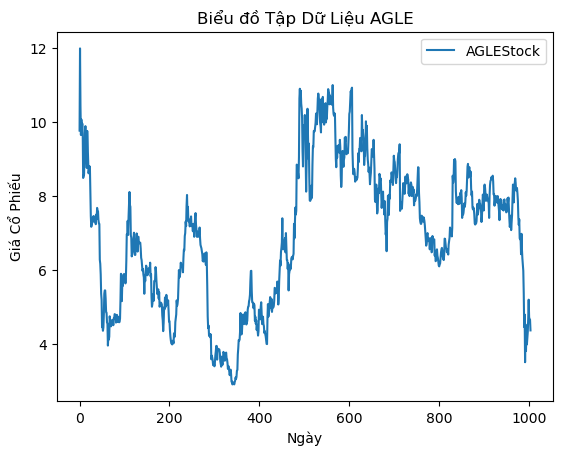

In [5]:
plt.title("Biểu đồ Tập Dữ Liệu "+nameData)
plt.plot(readData(filePath), label= nameData+'Stock')
plt.xlabel("Ngày")
plt.ylabel("Giá Cổ Phiếu")
plt.legend()
plt.show()


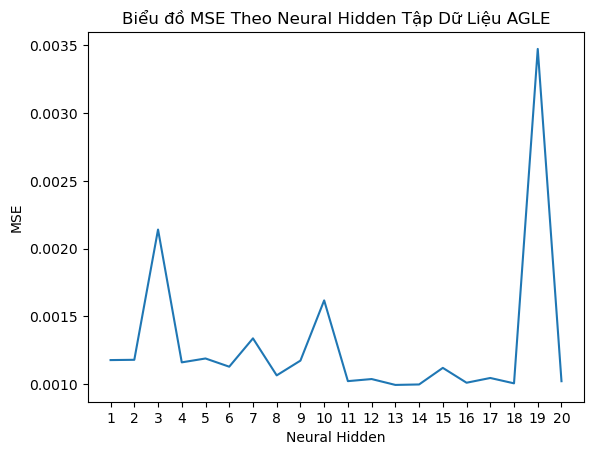

In [6]:
# Vẽ biểu đồ
plt.plot(range(1,len(df_MseWith_Neural[['MSE']])+1), df_MseWith_Neural[['MSE']])
plt.title("Biểu đồ MSE Theo Neural Hidden Tập Dữ Liệu "+nameData)
plt.xlabel("Neural Hidden")
plt.ylabel("MSE")
plt.xticks(range(1,len(df_MseWith_Neural[['MSE']])+1))
plt.show()

In [7]:
df_MseWith_Neural_Sort = df_MseWith_Neural.sort_values('MSE')
best_Neural=df_MseWith_Neural_Sort['Neural Hidden'].iloc[0]

In [8]:
df_MseWith_Neural_Sort

,Neural Hidden,Batch_Size,Epoch,MSE,Time Train,Time Test,Total Time
12,13.0,8.0,200.0,0.000996,1321.600036,0.521678,1322.121714
13,14.0,8.0,300.0,0.000999,1384.926064,0.397636,1385.323700
17,18.0,8.0,300.0,0.001007,1373.209046,0.624206,1373.833252
15,16.0,8.0,300.0,0.001012,1330.555277,0.476617,1331.031894
19,20.0,8.0,250.0,0.001023,1161.609637,0.339195,1161.948832
10,11.0,8.0,250.0,0.001023,1336.214132,0.576828,1336.790960
11,12.0,8.0,200.0,0.001039,1318.589969,0.297079,1318.887048
16,17.0,8.0,250.0,0.001047,1284.195589,0.406231,1284.601820
7,8.0,8.0,300.0,0.001066,1308.059547,0.632085,1308.691632
14,15.0,16.0,300.0,0.001121,1235.889580,0.345909,1236.235489


In [9]:
best_Neural

13.0

7/7 [==============================] - 0s 3ms/step


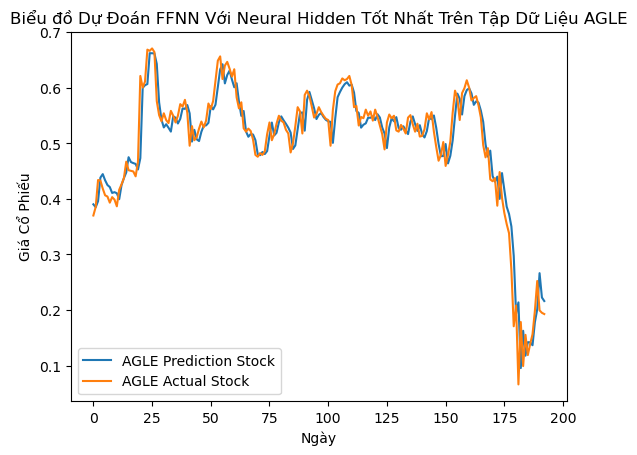

In [15]:
# Vẽ biểu đồ
best_param = {'batch_size': df_MseWith_Neural_Sort['Batch_Size'].iloc[0],
              'epochs': df_MseWith_Neural_Sort['Epoch'].iloc[0],
              'neuralHidden': df_MseWith_Neural_Sort['Neural Hidden'].iloc[0],
              'num_layers_hidden' : numHiddenLayer,
              'neuralInput' : size_window,
              'neuralOutput' : size_predict}
y_pred= predict_FFNN(nameData, 'FFNN_Find_NeuralHidden', X_train, y_train, X_test, best_param)

plt.title("Biểu đồ Dự Đoán FFNN Với Neural Hidden Tốt Nhất Trên Tập Dữ Liệu "+nameData)
plt.plot(y_pred, label=nameData+' Prediction Stock')
plt.plot(y_test, label=nameData+' Actual Stock')
plt.xlabel("Ngày")
plt.ylabel("Giá Cổ Phiếu")
plt.legend()
plt.show()

# Load Predict

In [14]:
# neural=range(1,21)
# batch_size=[8,
# 8,
# 16,
# 8,
# 8,
# 8,
# 8,
# 8,
# 8,
# 16,
# 8,
# 8,
# 8,
# 8,
# 16,
# 8,
# 8,
# 8,
# 16,
# 8
# ]
# epochs=[300,
# 300,
# 300,
# 300,
# 200,
# 300,
# 200,
# 300,
# 300,
# 250,
# 250,
# 200,
# 200,
# 300,
# 300,
# 300,
# 250,
# 300,
# 300,
# 250
# ]

# nameData= 'AGLE'
# filePath= '../../Dataset/'+nameData+'.csv'
# timeSeries = readData(filePath)
# timeSeries = cleanData(timeSeries)
# percentTrain = 80
# train_data, test_data = splitData(timeSeries, percentTrain)

# size_window = 7
# size_predict=1
# stepWindow=1
# X_train, y_train = prepare_data(train_data.values, size_window, size_predict, stepWindow)
# X_test, y_test =   prepare_data(test_data.values, size_window, size_predict, stepWindow)

# numHiddenLayer= 1

# df_MseWith_Neural = pd.DataFrame([],  columns =  ["Neural Hidden","Batch_Size","Epoch", "MSE"])

# for i in range(len(neural)):

#     best_param = {'batch_size': batch_size[i],
#               'epochs': epochs[i],
#               'neuralHidden': neural[i],
#               'num_layers_hidden' : numHiddenLayer,
#               'neuralInput' : size_window,
#               'neuralOutput' : size_predict}
#     y_pred= predict_FFNN(nameData, 'FFNN_Find_NeuralHidden', X_train, y_train, X_test, best_param)
#     rowMseWithNeural = pd.Series([neural[i],batch_size[i],epochs[i], mean_squared_error(y_test , y_pred)], index=df_MseWith_Neural.columns)
#     df_MseWith_Neural = df_MseWith_Neural.append(rowMseWithNeural,ignore_index=True)
# df_MseWith_Neural
# df_MseWith_Neural_Sort = df_MseWith_Neural.sort_values('MSE')
# best_Neural=df_MseWith_Neural_Sort['Neural Hidden'].iloc[0]

7/7 [==============================] - 0s 2ms/step


Thay thế các giá trị null bằng 0 .

Loại bỏ các giá trị nhiễu bằng cách thay thế các giá trị nằm ngoài khoảng 3 độ lệch chuẩn của dữ liệu với giá trị trung bình của dữ liệu.

MinMaxScaler để chuyển đổi dữ liệu thành phạm vi [0, 1]. Tiếp theo, chúng ta sử dụng 

Interpolate để điền vào các giá trị bị thiếu bằng cách lấy trung bình của các giá trị trước và sau đó.


std() là một hàm trong Python để tính độ lệch chuẩn của một tập dữ liệu. 

Công thức tính độ lệch chuẩn của một tập dữ liệu là:
σ = sqrt(1/n * Σ(xi - x_mean)^2)

Ví dụ, nếu chúng ta có tập dữ liệu [2, 4, 6, 8], thì giá trị trung bình là 5, độ lệch của mỗi giá trị so với giá trị trung bình lần lượt là [-3, -1, 1, 3], giá trị bình phương độ lệch của mỗi giá trị so với giá trị trung bình lần lượt là [9, 1, 1, 9], đưa vào công thức độ lệch chuẩn
 ==> σ = sqrt(1/4 * (9 + 1 + 1 + 9)) = sqrt(20/4) = sqrt(5) ≈ 2.236

